In [39]:
!pwd
%reload_ext autoreload
%autoreload 2

/Users/samiamer/Documents/School_Files/2022_Junior/Spring_2022/9.60/final_proj/texture-vs-shape


In [15]:
%cd texture-vs-shape

[Errno 2] No such file or directory: 'texture-vs-shape'
/Users/samiamer/Documents/School_Files/2022_Junior/Spring_2022/9.60/final_proj/texture-vs-shape


In [ ]:
import torchvision.models as models
convnext_base = models.convnext_base(pretrained=True)

In [73]:
%autoreload
import torch,torchvision
from models.load_pretrained_models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
device = torch.device("cpu")

model_A = "resnet50_trained_on_SIN"
model_B = "resnet50_trained_on_SIN_and_IN"
model_C = "resnet50_trained_on_SIN_and_IN_then_finetuned_on_IN"

model_ft = load_model(model_name = model_A)
model_ft = model_ft.module
for param in model_ft.parameters():
    param.requires_grad = False

for param in convnext_base.parameters():
    param.requires_grad = False

Using the ResNet50 architecture.


In [77]:
from torchvision import transforms
from torchvision import datasets
# TRANSFORM_IMG = transforms.Compose([transforms.ToTensor()])

def wp_preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]

    x[:,:,0] -=  133.104
    x[:,:,0] -=  119.973
    x[:,:,0] -=  104.432

    return x

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# test_loader = torchvision.datasets.ImageFolder("../rasta/data/wikipaintings_small/wikipaintings_test",transform=TRANSFORM_IMG)
# train_loader = torchvision.datasets.ImageFolder("../rasta/data/wikipaintings_small/wikipaintings_train",transform=TRANSFORM_IMG)

d_size = "small"

data_dir = f'../rasta/data/wikipaintings_{d_size}/wikipaintings_'
image_datasets = {x: datasets.ImageFolder(data_dir+x,
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# test_loader.class_to_idx

cpu


In [72]:
for i in range(len(image_datasets['train'])):
    sample = image_datasets['train'][i]
    # print(sample[1])
    print(i, sample[0].size(), sample[1])
    break

0 torch.Size([3, 224, 224]) 0


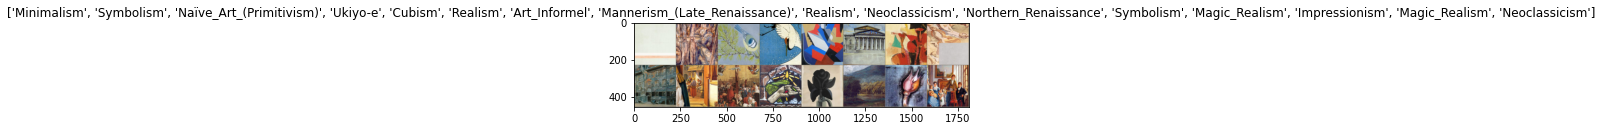

In [78]:
import numpy as np
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [43]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [44]:
import time
import os
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [45]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_ftrs = convnext_base.fc.in_features
convnext_base.fc = nn.Linear(num_ftrs, len(class_names))
convnext_base = convnext_base.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_convnext = optim.SGD(convnext_base.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_convnext = lr_scheduler.StepLR(optimizer_convnext, step_size=7, gamma=0.1)

In [46]:
pytorch_total_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in convnext_base.parameters() if p.requires_grad)
print(pytorch_total_params)

51225


In [47]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

# convnext_base = train_model(convnext_base, criterion, optimizer_convnext, exp_lr_scheduler_convnext,
#                        num_epochs=10)

Epoch 0/9
----------
train Loss: 3.2794 Acc: 0.0280
val Loss: 3.1910 Acc: 0.0760

Epoch 1/9
----------
train Loss: 3.1354 Acc: 0.1000
val Loss: 3.1381 Acc: 0.0840

Epoch 2/9
----------
train Loss: 2.9143 Acc: 0.2720
val Loss: 3.0488 Acc: 0.1760

Epoch 3/9
----------
train Loss: 2.7904 Acc: 0.3200
val Loss: 2.9872 Acc: 0.1960

Epoch 4/9
----------
train Loss: 2.6302 Acc: 0.3840
val Loss: 2.9342 Acc: 0.2320

Epoch 5/9
----------
train Loss: 2.5268 Acc: 0.4760


KeyboardInterrupt: 

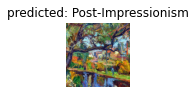

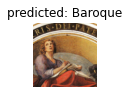

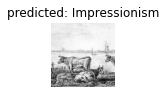

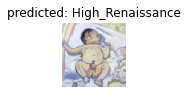

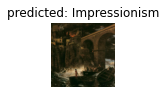

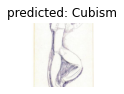

In [33]:
visualize_model(model_ft)